# $5^{th}$ exercises
## Notebook setup
#### Used libraries

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

#### Reading and printing config files

In [2]:
def LoadConfig(path):
    d={}
    with open(path) as file:
        for line in file:
            (directive,key, val) = line.split()
            if(directive=="#define"): d[key] = int(val)
    return d

def PrintConf(d):
    for key, val in d.items(): print("{0:<19}{1}".format(key,val))

#### Colors, just for fun

In [3]:
stb = "#191724" #background
ndb = "#26233a" #object background
ste = "#e0def4" #main elements
nde = "#f6c177" #additional elements
rde = "#eb6f92" #element in evidence
err = "#908caa" #error bar
er2 = "#6e6a86" #second error bar

### 05.1 Hydrogen atom

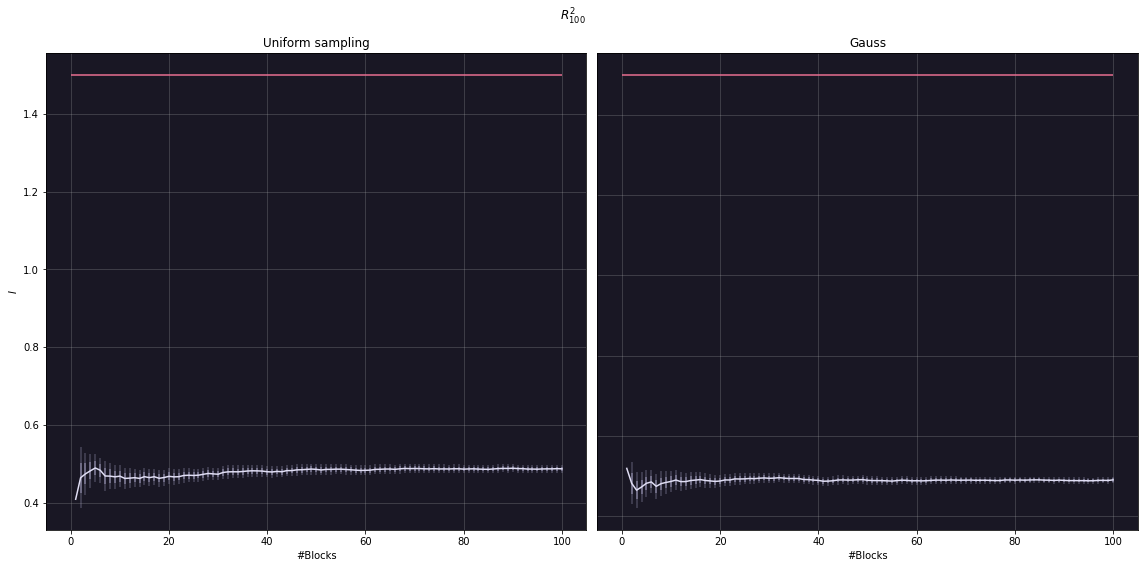

In [30]:
fig=plt.figure(figsize=(16, 8))
plt.suptitle('$R^2_{100}$', weight='bold')

#uniform 
data = np.genfromtxt("out/051-r2_100_unif.csv", delimiter=",", skip_header=1)
x=data[:,0]
y=data[:,3]
e=data[:,4]

plt.subplot(121)
fig.axes[0].set_facecolor(stb)

#plt.ylim(y_inf,y_sup)
plt.hlines(1.5,0, 100,color=rde)
#plt.hlines(1.5,0, conf["N_BLOCKS"],color=rde)
#posso mettere insieme a errorbar? ha senso cambiare tipo di grafico?
plt.vlines(x,y-e,y+e,color=err,alpha=0.8)
plt.vlines(x,y-2*e,y+2*e,color=err,alpha=0.4)
plt.errorbar(x,y,color=ste)

plt.xlabel('#Blocks')
plt.ylabel('$I$')
plt.title("Uniform sampling")
plt.grid(alpha=0.3)

#importance 
data = np.genfromtxt("out/051-r2_100_gaus.csv", delimiter=",", skip_header=1)
x=data[:,0]
y=data[:,3]
e=data[:,4]

plt.subplot(122)
fig.axes[1].set_facecolor(stb)

#plt.ylim(y_inf,y_sup)
plt.hlines(1.5,0, 100,color=rde)
#plt.hlines(1.5,0, conf["N_BLOCKS"],color=rde)
#posso mettere insieme a errorbar? ha senso cambiare tipo di grafico?
plt.vlines(x,y-e,y+e,color=err,alpha=0.8)
plt.vlines(x,y-2*e,y+2*e,color=err,alpha=0.4)
plt.errorbar(x,y,color=ste)

plt.tick_params(left=False,labelleft=False)
plt.xlabel('#Blocks')
plt.title("Gauss")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


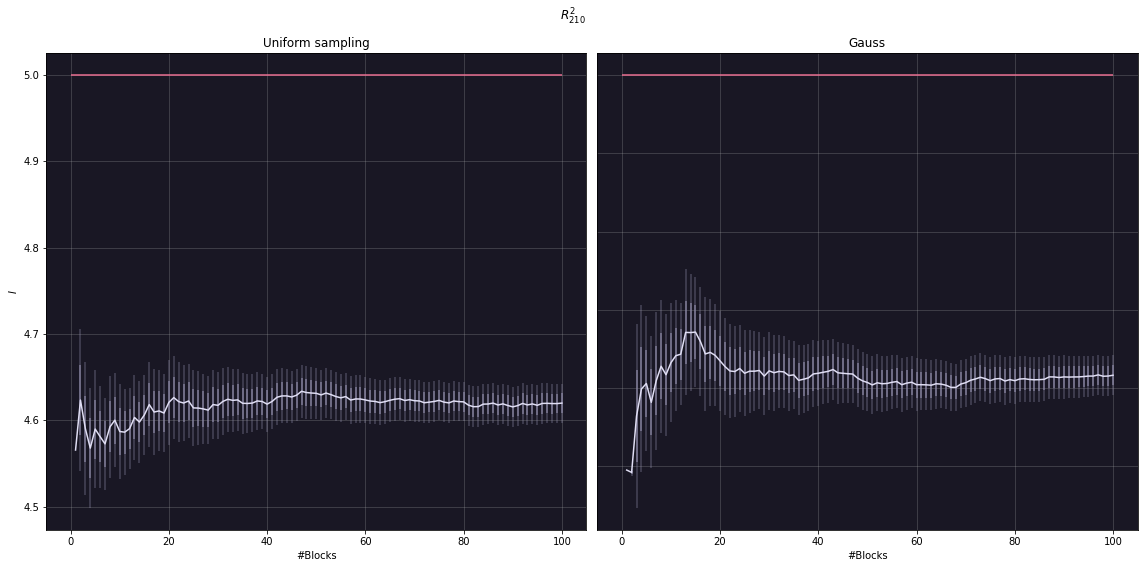

In [29]:
fig=plt.figure(figsize=(16, 8))
plt.suptitle('$R^2_{210}$', weight='bold')

#uniform 
data = np.genfromtxt("out/051-r2_210_unif.csv", delimiter=",", skip_header=1)
x=data[:,0]
y=data[:,3]
e=data[:,4]

plt.subplot(121)
fig.axes[0].set_facecolor(stb)

#plt.ylim(y_inf,y_sup)
plt.hlines(5,0, 100,color=rde)
#plt.hlines(5,0, conf["N_BLOCKS"],color=rde)
#posso mettere insieme a errorbar? ha senso cambiare tipo di grafico?
plt.vlines(x,y-e,y+e,color=err,alpha=0.8)
plt.vlines(x,y-2*e,y+2*e,color=err,alpha=0.4)
plt.errorbar(x,y,color=ste)

plt.xlabel('#Blocks')
plt.ylabel('$I$')
plt.title("Uniform sampling")
plt.grid(alpha=0.3)

#importance 
data = np.genfromtxt("out/051-r2_210_gaus.csv", delimiter=",", skip_header=1)
x=data[:,0]
y=data[:,3]
e=data[:,4]

plt.subplot(122)
fig.axes[1].set_facecolor(stb)

#plt.ylim(y_inf,y_sup)
plt.hlines(5,0, 100,color=rde)
#plt.hlines(5,0, conf["N_BLOCKS"],color=rde)
#posso mettere insieme a errorbar? ha senso cambiare tipo di grafico?
plt.vlines(x,y-e,y+e,color=err,alpha=0.8)
plt.vlines(x,y-2*e,y+2*e,color=err,alpha=0.4)
plt.errorbar(x,y,color=ste)

plt.tick_params(left=False,labelleft=False)
plt.xlabel('#Blocks')
plt.title("Gauss")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


/tmp/ipykernel_14724/2353346064.py:12: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


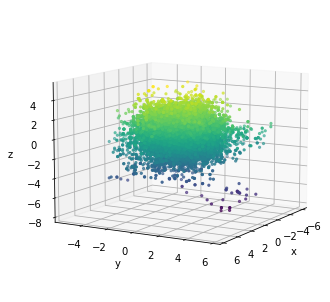

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
data = np.genfromtxt("Data/points.csv", delimiter=",", skip_header=1)

X=data[:,0]
Y=data[:,1]
Z=data[:,2]

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X, Y, Z, c=Z, marker='.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 30)
plt.show()

## 